In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import time

import tensorflow as tf
from tensorflow import keras


In [2]:
# Read the CSV file
csv_file_path = "C:\\Users\\Suhani\\Desktop\\vscode\\ann\\btm_hourly_2.csv"
df = pd.read_csv(csv_file_path)
df = df.apply(pd.to_numeric, errors='coerce')
df.replace('None', pd.NA, inplace=True)
print(df.head())

    PM10     NO    NO2    NOx    NH3  ...  WS  WD     SR      BP  PM2.5
0  51.35  12.02  15.63  36.59  11.20  ... NaN NaN  24.84  775.05  26.16
1  56.15  12.37  15.70  35.90  11.19  ... NaN NaN  23.62  775.00  28.46
2  46.53  11.68  16.48  36.20  11.37  ... NaN NaN  22.83  775.00  23.87
3  52.02  12.07  15.87  37.06  11.33  ... NaN NaN  23.75  775.00  26.49
4  48.19  11.80  16.07  35.90  11.57  ... NaN NaN  24.12  775.02  24.66

[5 rows x 18 columns]


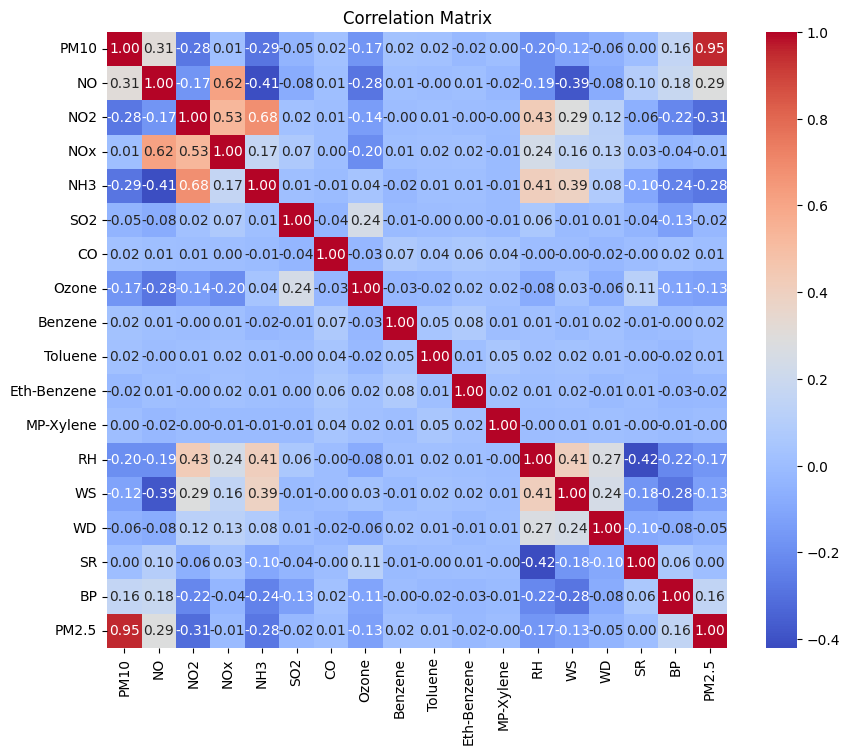

In [3]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [4]:
# Separating features and target variable
X = df.drop('PM2.5', axis=1)  # Features
y = df['PM2.5']  # Target variable
print(X.head())
print(y.head())

    PM10     NO    NO2    NOx    NH3  ...     RH  WS  WD     SR      BP
0  51.35  12.02  15.63  36.59  11.20  ...  82.03 NaN NaN  24.84  775.05
1  56.15  12.37  15.70  35.90  11.19  ...  87.23 NaN NaN  23.62  775.00
2  46.53  11.68  16.48  36.20  11.37  ...  89.23 NaN NaN  22.83  775.00
3  52.02  12.07  15.87  37.06  11.33  ...  89.25 NaN NaN  23.75  775.00
4  48.19  11.80  16.07  35.90  11.57  ...  89.25 NaN NaN  24.12  775.02

[5 rows x 17 columns]
0    26.16
1    28.46
2    23.87
3    26.49
4    24.66
Name: PM2.5, dtype: float64


In [5]:
# Creating SimpleImputer instance to impute missing values with the mean
imputer_x = SimpleImputer(strategy='most_frequent')
# Creating SimpleImputer instance to impute missing values with the mean for y
imputer_y = SimpleImputer(strategy='most_frequent')
X_imputed=pd.DataFrame(imputer_x.fit_transform(df.drop('PM2.5', axis=1)), columns=df.columns[:-1])
y_imputed=pd.DataFrame(imputer_y.fit_transform (df['PM2.5'].values.reshape(-1, 1)), columns=['PM2.5'])
print(X_imputed.head())
print(y_imputed.head())



    PM10     NO    NO2    NOx    NH3  ...     RH    WS      WD     SR      BP
0  51.35  12.02  15.63  36.59  11.20  ...  82.03  0.97  242.91  24.84  775.05
1  56.15  12.37  15.70  35.90  11.19  ...  87.23  0.97  242.91  23.62  775.00
2  46.53  11.68  16.48  36.20  11.37  ...  89.23  0.97  242.91  22.83  775.00
3  52.02  12.07  15.87  37.06  11.33  ...  89.25  0.97  242.91  23.75  775.00
4  48.19  11.80  16.07  35.90  11.57  ...  89.25  0.97  242.91  24.12  775.02

[5 rows x 17 columns]
   PM2.5
0  26.16
1  28.46
2  23.87
3  26.49
4  24.66


In [6]:
#normalization
# Create MinMaxScaler objects
PredictorScaler = MinMaxScaler()
TargetVarScaler = MinMaxScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_imputed)
TargetVarScalerFit = TargetVarScaler.fit(y_imputed.values.reshape(-1, 1))  # Reshape y if it's a 1D array

# Generating the standardized values of X and y
X_normalized = pd.DataFrame(PredictorScalerFit.transform(X_imputed), columns=df.columns[:-1])
y_normalized = pd.DataFrame(TargetVarScalerFit.transform(y_imputed.values.reshape(-1, 1)).flatten(),columns=['PM2.5'])  # Reshape back to 1D array
print(X_normalized.head())
print(y_normalized.head())



       PM10        NO       NO2  ...        WD        SR        BP
0  0.051322  0.399399  0.258929  ...  0.682236  0.024758  0.193734
1  0.056122  0.420420  0.263393  ...  0.682236  0.023518  0.193605
2  0.046502  0.378979  0.313138  ...  0.682236  0.022715  0.193605
3  0.051992  0.402402  0.274235  ...  0.682236  0.023650  0.193605
4  0.048162  0.386186  0.286990  ...  0.682236  0.024026  0.193657

[5 rows x 17 columns]
      PM2.5
0  0.034077
1  0.036998
2  0.031169
3  0.034496
4  0.032172


In [7]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.25, random_state=42)


In [9]:
# Function to generate Deep ANN model 
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=3, input_dim=17, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import time
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import Callback

class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': []}  # Add more metrics if needed

    def on_epoch_end(self, epoch, logs=None):
        self.history['loss'].append(logs['loss'])
        self.history['val_loss'].append(logs['val_loss'])
        # Add more metrics if needed


# Assuming you have defined make_regression_ann somewhere in your code

# Listing all the parameters to try
Parameter_Trials = {'batch_size': [64,128,256],
                    'epochs': [10,20,30,40,50],
                    'Optimizer_trial': ['adam', 'rmsprop']}

# Creating the regression ANN model
RegModel = KerasRegressor(make_regression_ann, verbose=0)

# Defining a custom scoring function for regression
def custom_scoring(orig, pred):
    mae = np.mean(np.abs(orig - pred))
    print('#' * 70, 'Mean Absolute Error:', mae)
    return -mae  # Negative because GridSearchCV looks for the maximum value, and we want to minimize MAE

custom_scorer = make_scorer(custom_scoring, greater_is_better=False)

# Creating the Grid search space
grid_search = GridSearchCV(estimator=RegModel,
                           param_grid=Parameter_Trials,
                           scoring=custom_scorer,
                           cv=5)

# Measuring how much time it took to find the best params
start_time = time.time()

# Running Grid Search for different parameters
grid_search.fit(X_normalized, y_normalized, verbose=1)

end_time = time.time()
print("Total Time Taken: ", round((end_time - start_time) / 60), 'Minutes')

print('Printing Best parameters ')
print(grid_search.best_params_)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = KerasRegressor(make_regression_ann, **best_params, verbose=1)
best_model.fit(X_train, y_train)
test_predictions = best_model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


ImportError: cannot import name 'ModelCheckpoin' from 'tensorflow.keras.callbacks' (c:\Users\Suhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\api\_v2\keras\callbacks\__init__.py)